<a href="https://colab.research.google.com/github/giordanovitale/Prado-Museum-CNN/blob/main/Prado_Artists.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



1.   [Data Augmentation Techniques](https://medium.com/ymedialabs-innovation/data-augmentation-techniques-in-cnn-using-tensorflow-371ae43d5be9#8be0)
2.   [Model Architectures](https://medium.com/@navarai/unveiling-the-diversity-a-comprehensive-guide-to-types-of-cnn-architectures-9d70da0b4521)
3. [EfficientNet](https://towardsdatascience.com/complete-architectural-details-of-all-efficientnet-models-5fd5b736142)

Dataset Source: https://www.kaggle.com/datasets/maparla/prado-museum-pictures

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Jun  3 13:20:15 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0              44W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

# 0 - Load the necessary libraries

In [54]:
!pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.8/993.8 kB 16.0 MB/s eta 0:00:00


In [55]:
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import polars as pl

import tqdm
import os
import requests

from multiprocessing import cpu_count
from multiprocessing.pool import ThreadPool
import visualkeras as vk

from scipy.optimize import fsolve
from math import exp
import matplotlib.pyplot as plt

from collections import defaultdict

from google.colab import userdata

import keras.backend as K
from keras.layers import Layer
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, \
    AveragePooling2D, BatchNormalization, ReLU, PReLU, ZeroPadding2D, \
    GlobalAveragePooling2D, Input, DepthwiseConv2D, Add, Activation, Lambda, RandomFlip, \
    Rescaling, RandomContrast, RandomZoom, RandomRotation, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.applications.resnet_v2 import preprocess_input as resnet_v2_preproccessing
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input as efficientnet_preproccessing
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2B3
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input as vgg_preproccessing
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocessing

# Get rid of the extra stuff that gets downloaded
!rm -rf sample_data

In [47]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


In [48]:
INPUT_SHAPE = (224,224,3)

# 1 - Helper Functions

## 1.1 - Custom functions for parallel downloading

In [ ]:
def download_url(args):
    """
    Downloads a file from an url
    :param args: Tuple containing the url and filename
    :return: None
    """
    url, filename = args[0], args[1]
    try:
      r = requests.get(url)
      if r.status_code != 404:
        with open(filename, "wb") as f:
          f.write(r.content)

    except Exception as e:
      print("Exception in download_url():", e)

In [ ]:
def download_parallel(args):
    """
    Downloads urls in parallel
    :param args: List of tuples containing the url and filename
    :return: None
    """
    cpus = cpu_count()
    threadpool = ThreadPool(cpus)
    with tqdm.tqdm(total=len(args), desc="Downloading images") as pbar:
        for _ in threadpool.imap_unordered(download_url, args):
            pbar.update(1)
    threadpool.close()
    threadpool.join()

## 1.2 - Custom function for visualizing the model performance

In [67]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="whitegrid", rc=custom_params)

In [70]:
def plot_history(history, figsize=(12,6), y_lim_left=(0,1), y_lim_right=(0,1.02)):
    """
    Plots the loss and accuracy curves.
    :param df: the data frame containing the histories we want to plot
    :param y_lim: Tuple. If not differently specified, it's (0,1). Only applies to the accuracy plot.
    :return: None
    """
    fig, ax = plt.subplots(figsize=figsize, nrows=1, ncols=2)


    # Plot Loss
    sns.lineplot(data=history,
                 x="epoch",
                 y="val_loss",
                 ax=ax[0],
                 label="Validation Loss",
                 linewidth=2,
                 color="#F58939",
                 errorbar=None)

    sns.lineplot(data=history,
                 x="epoch",
                 y="loss",
                 ax=ax[0],
                 label="Training Loss",
                 linewidth=2,
                 color="#40CA37",
                 errorbar=None)

    # Plot Accuracy
    sns.lineplot(data=history,
                 x="epoch",
                 y="val_accuracy",
                 ax=ax[1],
                 label="Validation Accuracy",
                 linewidth=2,
                 color="#F58939",
                 errorbar=None)

    sns.lineplot(data=history,
                 x="epoch",
                 y="accuracy",
                 ax=ax[1],
                 label="Training Accuracy",
                 linewidth=2,
                 color="#40CA37",
                 errorbar=None)

    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Categorical Crossentropy")
    ax[0].set_title("Training Loss vs Validation Loss")
    ax[0].set_ylim(y_lim_left)
    ax[0].legend()

    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Accuracy (%)")
    ax[1].set_title("Training Accuracy vs Validation Accuracy")
    ax[1].set_ylim(y_lim_right)
    ax[1].legend(loc="lower right")

    plt.show()

## 1.3 - Learning rate scheduler.

In [8]:
def scheduler(epoch, lr):
    """
    Creates schedule to obtain an exponential decay of the learning rate
    :param epoch: Int. Epoch at which we start the decay of the learning rate
    :param lr: Float Learning rate for the optimiser
    :return: Learning rate for a given epoch
    """
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.05)

# 2 - Load the dataset using Kaggle API

My Username and Key have been secreted. Replace `userdata.get('KAGGLE_USERNAME')` and `userdata.get('KAGGLE_KEY')`with your username and key, respectively.

In [24]:
os.environ["KAGGLE_USERNAME"] = "userdata.get('KAGGLE_USERNAME')"
os.environ["KAGGLE_KEY"] = "userdata.get('KAGGLE_KEY')"
!kaggle datasets download maparla/prado-museum-pictures -f prado.csv
!unzip prado.csv.zip

Dataset URL: https://www.kaggle.com/datasets/maparla/prado-museum-pictures
License(s): MIT
prado.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  prado.csv.zip
replace prado.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

Create the dataframe from the unzipepd csv file.

In [25]:
df = pd.read_csv(os.path.join("prado.csv"))

Since no target class has been defined from the project assignment, I have to decide it. After a careful inspection of the columns, I found out that the more suitable ones are `author` and `technical_sheet_tecnica`. The latter seems more intriguing as it has more observations, thus being more suitable to big data algorithms.

In [26]:
df.shape

(13487, 30)

In [ ]:
df['author'].value_counts()

author
Anónimo                                                                       2698
Goya y Lucientes, Francisco de                                                1080
Bayeu y Subías, Francisco                                                      446
Haes, Carlos de                                                                326
Pizarro y Librado, Cecilio                                                     290
                                                                              ... 
Malombra, Pietro                                                                 1
Taller de Bellini, Giovanni                                                      1
Mattioli, Ludovico -Dibujante- (Autor de la obra original: Cignani, Carlo)       1
Ricci, Marco                                                                     1
García, Sergio                                                                   1
Name: count, Length: 2560, dtype: int64

In [ ]:
df['technical_sheet_tecnica'].value_counts().sort_values(ascending=False)[:10]

Exception in download_url(): [Errno 2] No such file or directory: 'data/pencil/59825391-c4b9-4f84-8d6f-413fa045a3ea.jpg'


technical_sheet_tecnica
Óleo                    4156
Acuñación               1118
Esculpido                550
Lápiz compuesto          476
Clarión; Lápiz negro     396
Albúmina                 395
Sanguina                 372
Lápiz                    259
Lápiz negro              237
Pluma; Tinta parda       214
Name: count, dtype: int64

In [28]:
df['technical_sheet_tecnica'].nunique()

841

Reduce the data set by keeping observations belonging to the 4 classes of interest only.

In [41]:
df = df[df['technical_sheet_tecnica'].isin(['Óleo',
                                            'Acuñación',
                                            'Esculpido',
                                            'Lápiz compuesto'])]

In [42]:
df.shape

(6300, 30)

In order to obtain the JPGs images, we need to start from the given URL column `work_image_url`.

In [12]:
df['work_id'] = df['work_image_url'].apply(lambda x: x.split('/')[-1])

Create the folders into which the images will be stored, according to their respective class.

The important columns are:
`['work_image_url', 'work_id', 'technical_sheet_tecnica']`

In [13]:
!mkdir model_logs

In [ ]:
!mkdir data

In [14]:
esp_techniques = ['Óleo', 'Acuñación', 'Esculpido', 'Lápiz compuesto']
eng_techniques = ['oil', 'minting', 'sculpture', 'pencil']

In [ ]:
# rm -rf data

In [ ]:
for technique in eng_techniques:
  !mkdir -p data/$technique

In [ ]:
download_list = list()

for esp_technique, eng_technique in zip(esp_techniques, eng_techniques):

  image_urls = list(df['work_image_url'].loc[df['technical_sheet_tecnica'] == esp_technique])
  image_names = list(df['work_id'].loc[df['technical_sheet_tecnica'] == esp_technique])
  image_names = [f"data/{eng_technique}/" + fn for fn in image_names]

  for url, fn in zip(image_urls, image_names):
    download_list.append((url, fn))

In [ ]:
len(download_list)

6300

In [ ]:
download_parallel(download_list)

## Class Imbalance

https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#class_weights

In [43]:
num_oils = df.loc[df['technical_sheet_tecnica']=='Óleo'].shape[0]
num_mintings = df.loc[df['technical_sheet_tecnica']=='Acuñación'].shape[0]
num_sculptures = df.loc[df['technical_sheet_tecnica']=='Esculpido'].shape[0]
num_pencils = df.loc[df['technical_sheet_tecnica']=='Lápiz compuesto'].shape[0]

num_total = df.shape[0]

In [44]:
class_weights = {
    0: round((1/num_oils)*num_total, 2),
    1: round((1/num_mintings)*num_total, 2),
    2: round((1/num_sculptures)*num_total, 2),
    3: round((1/num_pencils)*num_total, 2)
}

class_weights

{0: 1.52, 1: 5.64, 2: 11.45, 3: 13.24}

In [45]:
original_weights={
    0: round(num_oils/num_total, 2),
    1: round(num_mintings/num_total, 2),
    2: round(num_sculptures/num_total, 2),
    3: round(num_pencils/num_total, 2)
    }

original_weights

{0: 0.66, 1: 0.18, 2: 0.09, 3: 0.08}

In [40]:
num_total

13487

# 3 - Temporarily use loaded data and mount

In [1]:
import os
import sys
from google.colab import drive

drive.mount('/content/drive')
os.chdir("/content/drive/MyDrive/AMD")
!ls

Mounted at /content/drive
data  model_logs  Prado-Artists.ipynb  prado.csv  prado.csv.zip


In [31]:
train_ds, test_ds = tf.keras.utils.image_dataset_from_directory('/content/drive/MyDrive/AMD/data',
                                                                label_mode='int',
                                                                color_mode='rgb',
                                                                batch_size=32,
                                                                image_size=(224, 224),
                                                                shuffle=True,
                                                                seed=42,
                                                                validation_split=0.2,
                                                                subset='both',
                                                                labels='inferred',
                                                                class_names=['oil', 'minting', 'sculpture', 'pencil'])

Found 5935 files belonging to 4 classes.
Using 4748 files for training.
Using 1187 files for validation.


In [99]:
# Function to count the number of samples per class
def count_classes(dataset):
    class_counts = {}
    for images, labels in dataset:
        for label in labels.numpy():
            if label in class_counts:
                class_counts[label] += 1
            else:
                class_counts[label] = 1
    return class_counts

# Count classes in the training and validation datasets
train_class_counts = count_classes(train_ds)
test_class_counts = count_classes(test_ds)

# Print the counts
class_names = ['oil', 'minting', 'sculpture', 'pencil']
print("Training set class distribution:")
for i, count in train_class_counts.items():
    print(f"{class_names[i]}: {count}")

print("\nTest set class distribution:")
for i, count in test_class_counts.items():
    print(f"{class_names[i]}: {count}")


Training set class distribution:
oil: 3150
minting: 916
pencil: 360
sculpture: 322

Test set class distribution:
oil: 792
sculpture: 78
minting: 202
pencil: 115




---



https://www.tensorflow.org/tutorials/images/data_augmentation

From the link above:

> Note: Data augmentation is inactive at test time so input images will only be augmented during calls to Model.fit (not Model.evaluate or Model.predict).



In [32]:
num_classes = 4

- Larger kernels capture larger features, while smaller kernels capture finer details.
- The number of filters determines how many different types of features the network can detect at that layer. More filters allow for a richer and more diverse set of feature detections.


> These two parameters are independent but work together to shape the features that the Conv2D layer will extract from the input image.



***

# 4 - First Model: ZFNet

In [58]:
zfnet = Sequential([

    # Preprocessing layers
    tf.keras.layers.Rescaling(1./255,
                              input_shape=INPUT_SHAPE,
                              name='rescaling'),
    tf.keras.layers.RandomFlip(mode='horizontal_and_vertical',
                               input_shape=INPUT_SHAPE,
                               name='Random_Horizontal_And_Vertical_Flip'),
    tf.keras.layers.RandomRotation(factor=0.2,
                                   input_shape=INPUT_SHAPE,
                                   name='Random_Rotation'),
    tf.keras.layers.RandomContrast(factor=0.2,
                                   input_shape=INPUT_SHAPE,
                                   name='Random_Contrast'),
    tf.keras.layers.RandomZoom(height_factor=(-0.2, -0.1),
                               input_shape=INPUT_SHAPE,
                               name='Random_Zoom'),


    # 1st convolutional block
    Conv2D(filters=48,
           kernel_size=(7,7),
           strides=(2,2),
           padding='valid',
           activation=None,
           name='Conv_1'),
    ReLU(name='ReLU_1'),
    MaxPooling2D(pool_size=(3,3),
                 strides=(2,2),
                 padding='valid',
                 name='Max_Pooling_1'),

    # 2nd convolutional block
    Conv2D(filters=128,
           kernel_size=(3,3),
           strides=(2,2),
           padding='valid',
           activation=None,
           name='Conv_2'),
    ReLU(name='ReLU_2'),
    MaxPooling2D(pool_size=(3,3),
                 strides=(2,2),
                 padding='valid',
                 name='Max_Pooling_2'),

    # 3rd convolutional block
    Conv2D(filters=192,
           kernel_size=(3,3),
           strides=(1,1),
           padding='valid',
           activation=None,
           name='Conv_3.1'),
    ReLU(name='ReLU_3.1'),
    Conv2D(filters=192,
           kernel_size=(3,3),
           strides=(1,1),
           padding='valid',
           activation=None,
           name='Conv_3.2'),
    ReLU(name='ReLU_3.2'),
    Conv2D(filters=128,
           kernel_size=(3,3),
           strides=(1,1),
           padding='valid',
           activation=None,
           name='Conv_3.3'),
    ReLU(name='ReLU_3.3'),
    MaxPooling2D(pool_size=(3,3),
                 strides=(2,2),
                 padding='valid',
                 name='Max_Pooling_3'),

    # Flatten Layer
    Flatten(name='Flatten'),

    # 1st Dense Layer
    Dense(units=256,
          activation='relu',
          name='Dense_1'),

    # 2nd Dense Layer
    Dense(units=256,
          activation='relu',
          name='Dense_2'),

    # 3rd Dense Layer
    Dense(units=num_classes,
          activation='softmax',
          name="Output")
],
    name='ZFNet')

In [51]:
zfnet.build(input_shape=(None, *INPUT_SHAPE))
zfnet.summary()

Model: "ZFNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 Random_Horizontal_And_Vert  (None, 224, 224, 3)       0         
 ical_Flip (RandomFlip)                                          
                                                                 
 Random_Rotation (RandomRot  (None, 224, 224, 3)       0         
 ation)                                                          
                                                                 
 Random_Contrast (RandomCon  (None, 224, 224, 3)       0         
 trast)                                                          
                                                                 
 Random_Zoom (RandomZoom)    (None, 224, 224, 3)       0         
                                                             

Model compiling.

In [52]:
zfnet.compile(loss=SparseCategoricalCrossentropy(),
              optimizer=Adam(),
              metrics=["accuracy"])

Create csv logger to save the results in case it stops.

In [23]:
zfnet_csv_logger = CSVLogger("/content/drive/MyDrive/AMD/model_logs/zfnet.log")

Train the model.

In [24]:
zfnet_history = zfnet.fit(train_ds,
                          epochs=50,
                          steps_per_epoch=len(train_ds),
                          validation_data=test_ds,
                          validation_steps=len(test_ds),
                          class_weight=class_weights,
                          callbacks=zfnet_csv_logger)

Epoch 1/50
149/149 [==============================] - 555s 3s/step - loss: 0.1563 - accuracy: 0.6782 - val_loss: 0.9847 - val_accuracy: 0.7186
Epoch 2/50
149/149 [==============================] - 33s 211ms/step - loss: 0.1512 - accuracy: 0.6961 - val_loss: 1.3358 - val_accuracy: 0.7119
Epoch 3/50
149/149 [==============================] - 33s 212ms/step - loss: 0.1494 - accuracy: 0.6982 - val_loss: 0.5405 - val_accuracy: 0.7195
Epoch 4/50
149/149 [==============================] - 33s 211ms/step - loss: 0.0883 - accuracy: 0.8328 - val_loss: 0.2739 - val_accuracy: 0.9275
Epoch 5/50
149/149 [==============================] - 33s 213ms/step - loss: 0.0575 - accuracy: 0.8981 - val_loss: 0.4897 - val_accuracy: 0.8896
Epoch 6/50
149/149 [==============================] - 33s 210ms/step - loss: 0.0530 - accuracy: 0.9019 - val_loss: 0.4818 - val_accuracy: 0.8433
Epoch 7/50
149/149 [==============================] - 33s 210ms/step - loss: 0.0567 - accuracy: 0.8787 - val_loss: 0.4245 - val_accu

Visualize the architecture.

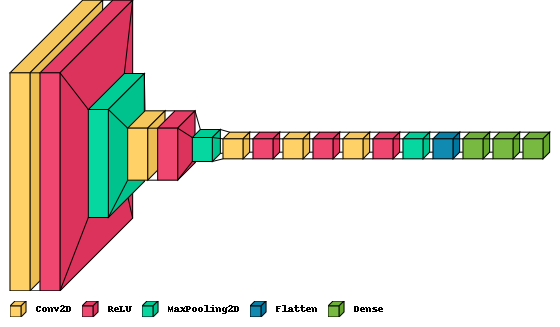

In [59]:
color_map = defaultdict(dict)

# Assign the same color to all the preprocessing steps
color_map[Rescaling]["fill"] = "#3785CD"
color_map[RandomFlip]["fill"] = "#3785CD"
color_map[RandomRotation]["fill"] = "#3785CD"
color_map[RandomContrast]["fill"] = "#3785CD"
color_map[RandomZoom]["fill"] = "#3785CD"
color_map[Lambda]["fill"] = "#3785CD"


color_map[AveragePooling2D]["fill"] = "#25bdf0"
color_map[Dense]["fill"] = "#78ba41"

vk.layered_view(zfnet,
                legend=True,
                scale_xy=2,
                scale_z=.01,
                type_ignore=[Rescaling, RandomFlip, RandomRotation, RandomContrast,
                RandomZoom, Lambda],
                color_map=color_map
                )

Visualize its performance.

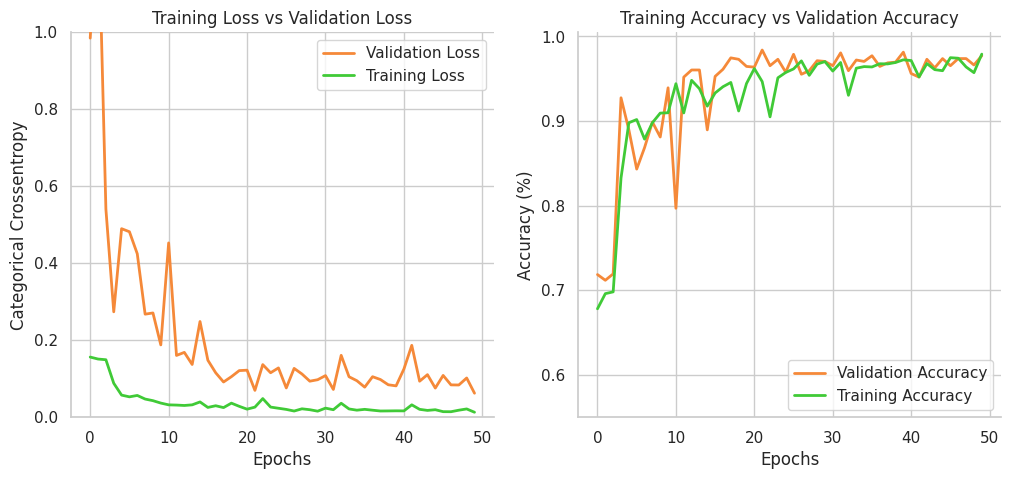

In [74]:
zfnet_history = pd.read_csv("/content/drive/MyDrive/AMD/model_logs/zfnet.log")
plot_history(zfnet_history, y_lim_right=(0.55,1.005), figsize=(12,5))

# 5 - Second Model: GioNet

In [27]:
gionet = Sequential([

    # Preprocessing layers
    tf.keras.layers.Rescaling(1./255,
                              input_shape=INPUT_SHAPE,
                              name='Rescaling'),
    tf.keras.layers.RandomFlip(mode='horizontal_and_vertical',
                               input_shape=INPUT_SHAPE,
                               name='Random_Horizontal_And_Vertical_Flip'),
    tf.keras.layers.RandomRotation(factor=0.2,
                                   input_shape=INPUT_SHAPE,
                                   name='Random_Rotation'),
    tf.keras.layers.RandomContrast(factor=0.2,
                                   input_shape=INPUT_SHAPE,
                                   name='Random_Contrast'),
    tf.keras.layers.RandomZoom(height_factor=(-0.2, -0.1),
                               input_shape=INPUT_SHAPE,
                               name='Random_Zoom'),
    tf.keras.layers.Lambda(function=tf.image.per_image_standardization,
                           name="Per_image_standardisation"),


    # 1st convolutional block
    Conv2D(filters=224,
           kernel_size=(3,3),
           strides=(2,2),
           padding='same',
           activation=None,
           name='Conv_1'),
    ReLU(name='ReLU_1'),
    AveragePooling2D(pool_size=(3,3),
                     strides=(2,2),
                     padding='same',
                     name='Avg_Pooling_1'),


    # 2nd convolutional block
    Conv2D(filters=112,
           kernel_size=(3,3),
           strides=(2,2),
           padding='same',
           activation=None,
           name='Conv_2'),
    ReLU(name='ReLU_2'),
    AveragePooling2D(pool_size=(3,3),
                     strides=(2,2),
                     padding='same',
                     name='Avg_Pooling_2'),

    # 3rd convolutional block
    Conv2D(filters=56,
           kernel_size=(3,3),
           strides=(2,2),
           padding='same',
           activation=None,
           name='Conv_3'),
    ReLU(name='ReLU_3'),
    AveragePooling2D(pool_size=(3,3),
                     strides=(2,2),
                     padding='same',
                     name='Avg_Pooling_3'),

    # 4th convolutional block
    Conv2D(filters=28,
           kernel_size=(5,5),
           strides=(1,1),
           padding='same',
           activation=None,
           name='Conv_4.1'),
    ReLU(name='ReLU_4.1'),
    Conv2D(filters=28,
           kernel_size=(5,5),
           strides=(1,1),
           padding='same',
           activation=None,
           name='Conv_4.2'),
    ReLU(name='ReLU_4.2'),
    AveragePooling2D(pool_size=(3,3),
                     strides=(2,2),
                     padding='valid',
                     name='Avg_Pooling_4'),

    # Flatten Layer
    Flatten(name='Flatten'),

    # 1st Dense Layer
    Dense(units=64,
          activation='relu',
          name='Dense_1'),

    # 2nd Dense Layer
    Dense(units=num_classes,
          activation='softmax',
          name="Output")
],
    name='GioNet')

In [28]:
gionet.build(input_shape=(None, *INPUT_SHAPE))
gionet.summary()

Model: "GioNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 Random_Horizontal_And_Vert  (None, 224, 224, 3)       0         
 ical_Flip (RandomFlip)                                          
                                                                 
 Random_Rotation (RandomRot  (None, 224, 224, 3)       0         
 ation)                                                          
                                                                 
 Random_Contrast (RandomCon  (None, 224, 224, 3)       0         
 trast)                                                          
                                                                 
 Random_Zoom (RandomZoom)    (None, 224, 224, 3)       0         
                                                            

Compile the model

In [29]:
gionet.compile(loss=SparseCategoricalCrossentropy(),
               optimizer=Adam(),
               metrics=['accuracy'])

CSV logger in case it stops.

In [30]:
gionet_csv_logger = CSVLogger("/content/drive/MyDrive/AMD/model_logs/gionet.log")

Train the model.

In [31]:
gionet_history = gionet.fit(train_ds,
                            epochs=50,
                            steps_per_epoch=len(train_ds),
                            validation_data=test_ds,
                            validation_steps=len(test_ds),
                            class_weight=class_weights,
                            callbacks=gionet_csv_logger)

Epoch 1/50
149/149 [==============================] - 37s 203ms/step - loss: 0.1474 - accuracy: 0.7422 - val_loss: 0.6583 - val_accuracy: 0.7902
Epoch 2/50
149/149 [==============================] - 33s 211ms/step - loss: 0.0645 - accuracy: 0.8359 - val_loss: 0.8852 - val_accuracy: 0.8138
Epoch 3/50
149/149 [==============================] - 33s 211ms/step - loss: 0.0460 - accuracy: 0.8755 - val_loss: 0.3635 - val_accuracy: 0.9191
Epoch 4/50
149/149 [==============================] - 33s 211ms/step - loss: 0.0376 - accuracy: 0.9120 - val_loss: 0.2250 - val_accuracy: 0.9444
Epoch 5/50
149/149 [==============================] - 33s 210ms/step - loss: 0.0381 - accuracy: 0.9160 - val_loss: 0.3158 - val_accuracy: 0.9115
Epoch 6/50
149/149 [==============================] - 33s 210ms/step - loss: 0.0299 - accuracy: 0.9396 - val_loss: 0.1924 - val_accuracy: 0.9495
Epoch 7/50
149/149 [==============================] - 33s 210ms/step - loss: 0.0268 - accuracy: 0.9429 - val_loss: 0.2536 - val_ac

Visualize the architecture.

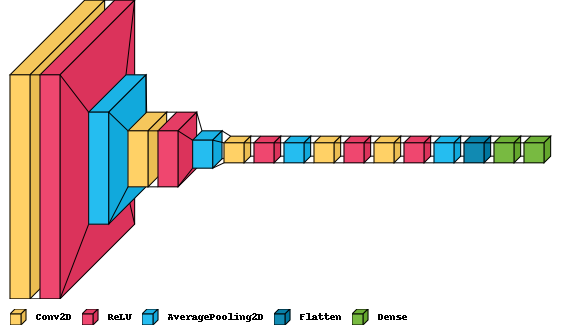

In [ ]:
color_map = defaultdict(dict)

# Assign the same color to all the preprocessing steps
color_map[Rescaling]["fill"] = "#3785CD"
color_map[RandomFlip]["fill"] = "#3785CD"
color_map[RandomRotation]["fill"] = "#3785CD"
color_map[RandomContrast]["fill"] = "#3785CD"
color_map[RandomZoom]["fill"] = "#3785CD"
color_map[Lambda]["fill"] = "#3785CD"


color_map[AveragePooling2D]["fill"] = "#25bdf0"
color_map[Dense]["fill"] = "#78ba41"

vk.layered_view(gionet,
                legend=True,
                scale_xy=2,
                scale_z=.01,
                type_ignore=[Rescaling, RandomFlip, RandomRotation, RandomContrast,
                RandomZoom, Lambda],
                color_map=color_map
                )

Visualize its performance.

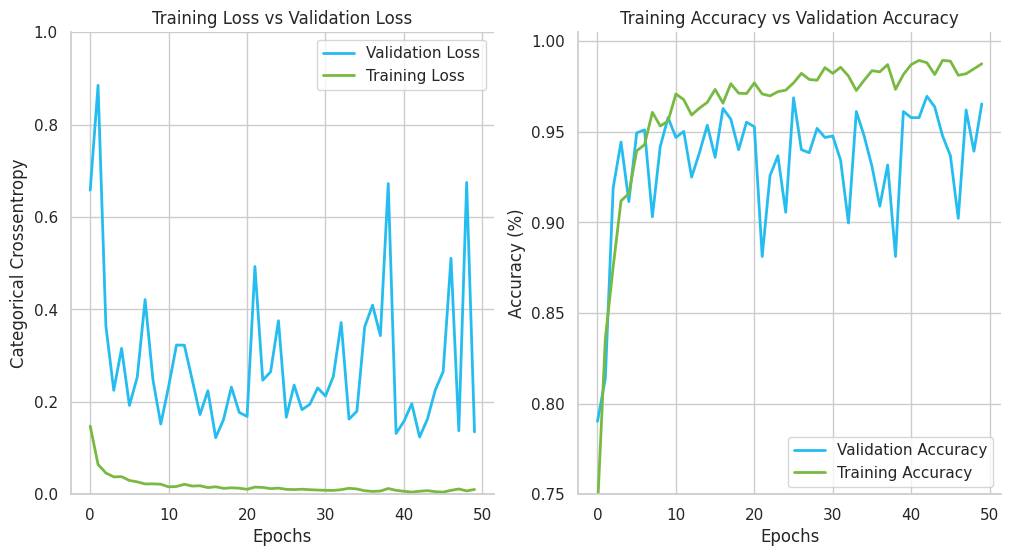

In [42]:
gionet_history = pd.read_csv("/content/drive/MyDrive/AMD/model_logs/gionet.log")
plot_history(gionet_history, y_lim_right=(0.75,1.005))

# 6 - Third Model: GioNetV2

Novelty in initializer: https://keras.io/api/layers/initializers/

In [32]:
gionetv2 = Sequential([

    # A bit difference in the pre-processing steps
    tf.keras.layers.Rescaling(1./255,
                              input_shape=INPUT_SHAPE,
                              name='rescaling'),
    tf.keras.layers.RandomFlip(mode='horizontal_and_vertical',
                               input_shape=INPUT_SHAPE,
                               name='Random_Horizontal_And_Vertical_Flip'),
    tf.keras.layers.RandomContrast(factor=0.2,
                                   input_shape=INPUT_SHAPE,
                                   name='Random_Contrast'),
    tf.keras.layers.Lambda(function=tf.image.per_image_standardization,
                           name='Per_image_standardisation'),

    # 1st convolutional block
    Conv2D(filters=32,
           kernel_size=(7,7),
           strides=(2,2),
           padding='same',
           activation=None,
           kernel_initializer='he_normal',
           name='Conv_1'),
    BatchNormalization(name='BatchNormalization_1'),
    ReLU(name='ReLU_1'),

    #2nd Convolutional block
    Conv2D(filters=64,
           kernel_size=(5,5),
           strides=(2,2),
           padding='same',
           activation=None,
           kernel_initializer='he_normal',
           name='Conv_2.1'),
    BatchNormalization(name='BatchNormalization_2.1'),
    ReLU(name='ReLU_2.1'),

    Conv2D(filters=64,
           kernel_size=(5,5),
           strides=(2,2),
           padding='same',
           activation=None,
           kernel_initializer='he_normal',
           name='Conv_2.2'),
    BatchNormalization(name='BatchNormalization_2.2'),
    ReLU(name='ReLU_2.2'),

    #3rd Convolutional block
    Conv2D(filters=128,
           kernel_size=(3,3),
           strides=(2,2),
           padding='same',
           activation=None,
           kernel_initializer='he_normal',
           name='Conv_3.1'),
    BatchNormalization(name='BatchNormalization_3.1'),
    ReLU(name='ReLU_3.1'),

    Conv2D(filters=128,
           kernel_size=(3,3),
           strides=(2,2),
           padding='same',
           activation=None,
           kernel_initializer='he_normal',
           name='Conv_3.2'),
    BatchNormalization(name='BatchNormalization_3.2'),
    ReLU(name='ReLU_3.2'),

    # Flatten layer
    Flatten(name='Flatten'),

   # Final Dense layer
    Dense(units=num_classes,
          activation='softmax',
          name='Output')

], name='GioNetV2')

In [80]:
gionetv2.build(input_shape=(None, *INPUT_SHAPE))
gionetv2.summary()

Model: "GioNetV2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 Random_Horizontal_And_Vert  (None, 224, 224, 3)       0         
 ical_Flip (RandomFlip)                                          
                                                                 
 Random_Contrast (RandomCon  (None, 224, 224, 3)       0         
 trast)                                                          
                                                                 
 Per_image_standardisation   (None, 224, 224, 3)       0         
 (Lambda)                                                        
                                                                 
 Conv_1 (Conv2D)             (None, 112, 112, 32)      4736      
                                                          

Compile the model.

In [33]:
gionetv2.compile(loss=SparseCategoricalCrossentropy(),
                 optimizer=Adam(),
                 metrics=['accuracy'])

CSV logger in case it stops.

In [34]:
gionetv2_csv_logger = CSVLogger("/content/drive/MyDrive/AMD/model_logs/gionetv2.log")
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

Train the model.

In [36]:
gionetv2_history = gionetv2.fit(train_ds,
                                epochs=50,
                                steps_per_epoch=len(train_ds),
                                validation_data=test_ds,
                                validation_steps=len(test_ds),
                                class_weight=class_weights,
                                callbacks=[gionetv2_csv_logger, lr_scheduler])

Epoch 1/50
149/149 [==============================] - 34s 216ms/step - loss: 3.1221e-04 - accuracy: 0.9996 - val_loss: 0.0420 - val_accuracy: 0.9924 - lr: 4.2742e-04
Epoch 2/50
149/149 [==============================] - 35s 222ms/step - loss: 1.6601e-04 - accuracy: 0.9996 - val_loss: 0.0418 - val_accuracy: 0.9924 - lr: 4.2742e-04
Epoch 3/50
149/149 [==============================] - 33s 213ms/step - loss: 1.1794e-04 - accuracy: 0.9996 - val_loss: 0.0430 - val_accuracy: 0.9933 - lr: 4.2742e-04
Epoch 4/50
149/149 [==============================] - 33s 215ms/step - loss: 9.2841e-05 - accuracy: 0.9998 - val_loss: 0.0447 - val_accuracy: 0.9933 - lr: 4.2742e-04
Epoch 5/50
149/149 [==============================] - 33s 213ms/step - loss: 1.8190e-04 - accuracy: 0.9996 - val_loss: 0.0434 - val_accuracy: 0.9916 - lr: 4.2742e-04
Epoch 6/50
149/149 [==============================] - 34s 216ms/step - loss: 2.7150e-04 - accuracy: 0.9998 - val_loss: 0.0442 - val_accuracy: 0.9941 - lr: 4.2742e-04
Epoc

Visualize the architecture.

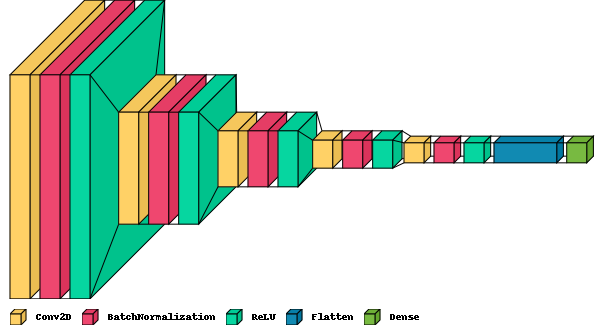

In [37]:
color_map = defaultdict(dict)

# Assign the same color to all the preprocessing steps
color_map[Rescaling]["fill"] = "#3785CD"
color_map[RandomFlip]["fill"] = "#3785CD"
color_map[RandomRotation]["fill"] = "#3785CD"
color_map[RandomContrast]["fill"] = "#3785CD"
color_map[RandomZoom]["fill"] = "#3785CD"
color_map[Lambda]["fill"] = "#3785CD"


color_map[AveragePooling2D]["fill"] = "#25bdf0"
color_map[Dense]["fill"] = "#78ba41"

vk.layered_view(gionetv2,
                legend=True,
                scale_xy=2,
                scale_z=.01,
                type_ignore=[Rescaling, RandomFlip, RandomRotation, RandomContrast,
                RandomZoom, Lambda],
                color_map=color_map
                )

Visualize its performance.

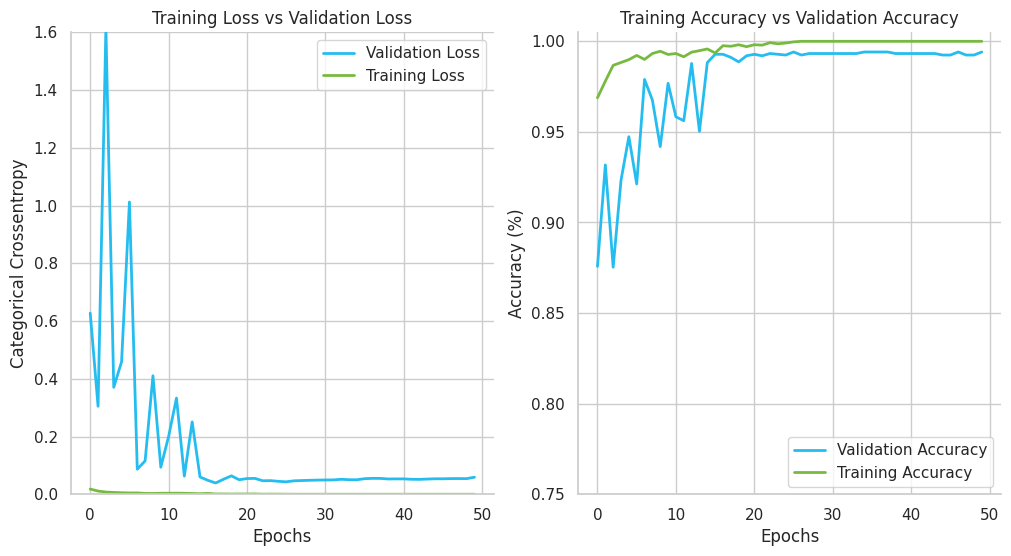

In [57]:
gionetv2_history = pd.read_csv("/content/drive/MyDrive/AMD/model_logs/gionetv2.log")
plot_history(gionetv2_history, y_lim_left=(0,1.6), y_lim_right=(0.75,1.005))

# 7 - Overall Comparison

In [16]:
gionetv2_history = pd.read_csv("/content/drive/MyDrive/AMD/model_logs/gionetv2.log")
gionet_history = pd.read_csv("/content/drive/MyDrive/AMD/model_logs/gionet.log")
zfnet_history = pd.read_csv('/content/drive/MyDrive/AMD/model_logs/zfnet.log')

## Seaborn

<ipython-input-17-c867d69d0924>:11: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




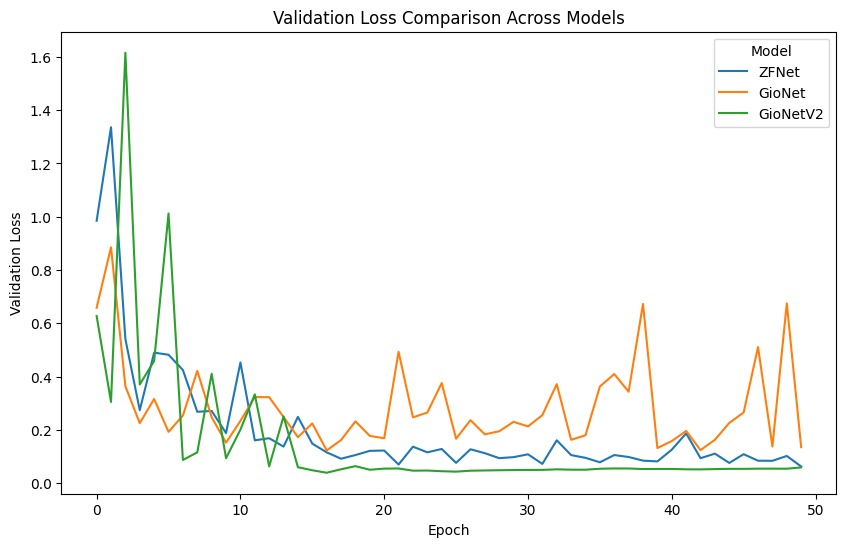

In [17]:
plt.figure(figsize=(10, 6))

sns.lineplot(data=zfnet_history,
             x='epoch',
             y='val_loss',
             label='ZFNet')
sns.lineplot(data=gionet_history,
             x='epoch',
             y='val_loss',
             label='GioNet')
sns.lineplot(data=gionetv2_history,
             x='epoch',
             y='val_loss',
             label='GioNetV2',
             ci=None)
plt.title('Validation Loss Comparison Across Models')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend(title='Model')

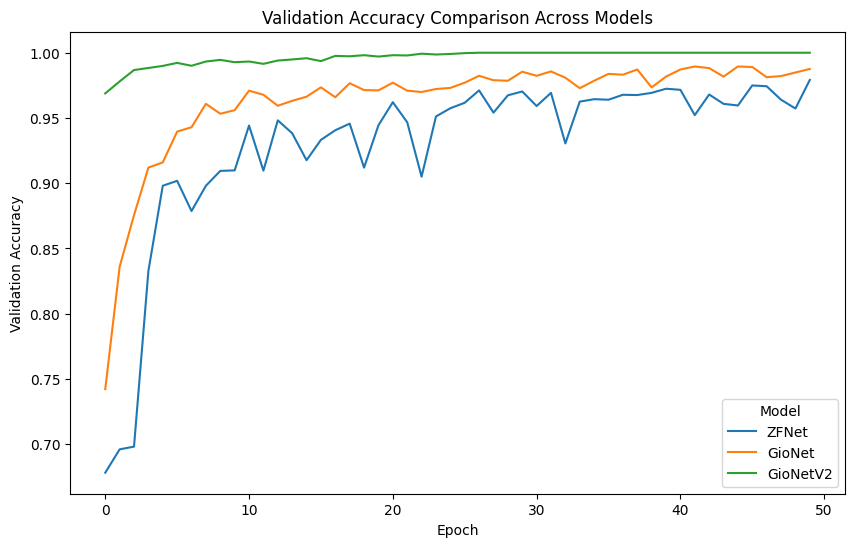

In [22]:
plt.figure(figsize=(10, 6))

sns.lineplot(data=zfnet_history,
             x='epoch',
             y='accuracy',
             label='ZFNet')
sns.lineplot(data=gionet_history,
             x='epoch',
             y='accuracy',
             label='GioNet')
sns.lineplot(data=gionetv2_history,
             x='epoch',
             y='accuracy',
             label='GioNetV2',
             errorbar=None)
plt.title('Validation Accuracy Comparison Across Models')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend(title='Model')

# 8 - Data augmentation plots for the report

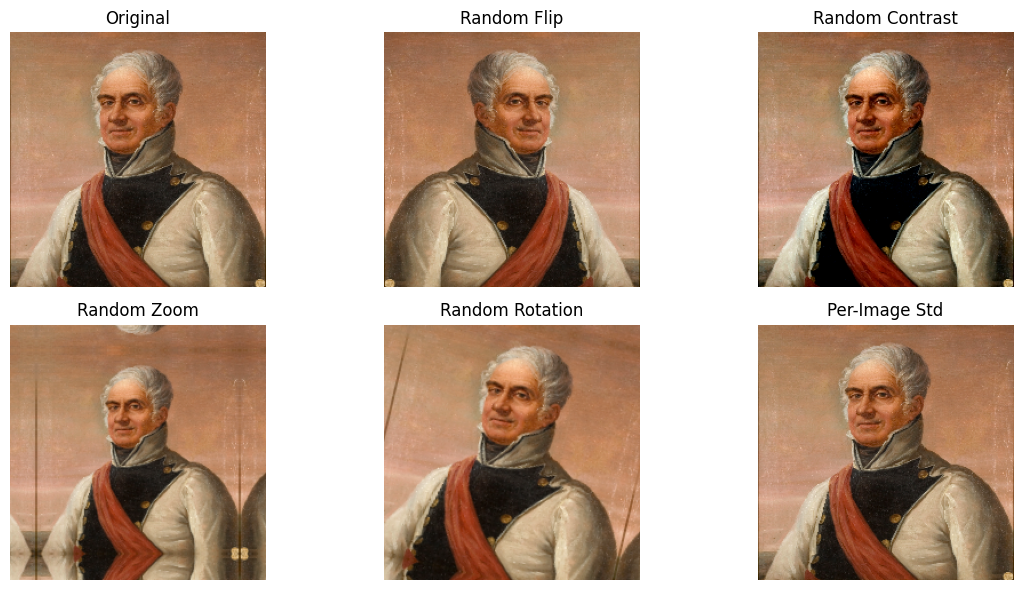

In [26]:
# Load a sample image
sample_image = tf.keras.preprocessing.image.load_img('/content/drive/MyDrive/AMD/data/oil/fff0f33e-1f29-481a-b8a9-4cc608153370.jpg',
                                                     grayscale=False,
                                                     color_mode='rgb')
sample_image = tf.keras.preprocessing.image.img_to_array(sample_image)
sample_image = tf.image.resize(sample_image, [224, 224])

# Define augmentation layers
random_flip = tf.keras.layers.RandomFlip(mode='horizontal_and_vertical')
random_contrast = tf.keras.layers.RandomContrast(factor=0.8)
random_zoom = tf.keras.layers.RandomZoom(height_factor=0.3)
random_rotation = tf.keras.layers.RandomRotation(factor=0.2)
per_image_stand = tf.keras.layers.Lambda(function=tf.image.per_image_standardization)

# Apply and visualize augmentations
augmented_images = {
    'Original': sample_image,
    'Random Flip': random_flip(sample_image),
    'Random Contrast': random_contrast(sample_image),
    'Random Zoom': random_zoom(sample_image),
    'Random Rotation': random_rotation(sample_image),
    'Per-Image Std': per_image_stand(sample_image)
}

# Plot original and augmented images
plt.figure(figsize=(12, 6))

for i, (title, img) in enumerate(augmented_images.items()):
    plt.subplot(2, 3, i+1)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(img))
    plt.title(title)
    plt.axis('off')

plt.tight_layout()
plt.show()

# Save the folders

In [ ]:
from google.colab import drive
import shutil

# Mount Google Drive
drive.mount('/content/drive')

# Define source and destination paths
source_path = '/content/data'
destination_path = '/content/drive/My Drive/AMD/data'

# Copy the folder to Google Drive
shutil.copytree(source_path, destination_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'/content/drive/My Drive/AMD/data'